<a href="https://colab.research.google.com/github/iritwikdas/assignment_predict_now_ai/blob/main/Meta_labelling_and_the_Triple_Barrier_Method_TESLA_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flow of algorithm

1. We will build a simple bollinger band strategy to identify long and short signals.

2. We will then apply the Triple Barrier Method outline above to determine our triple barrier events. (Discussed in another python notebook in this repo)

3. Then we will use forecasts from the primary model to generate meta-labels.

4. Finally we will use a random forest algorithm on the meta-labels to filter the “Buy” and “Sell” signals and improve the overall precision of the model

# Installing and Importing Requisite Packages (can skip this tab)




In [16]:
%%capture
pip install dask[dataframe] --upgrade

In [17]:
%%capture
pip install yfinance

In [18]:
%load_ext autoreload
%autoreload 2
# import standard libs
import yfinance as yf
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
import datetime as dt
import multiprocessing as mp
from datetime import datetime
from collections import OrderedDict as od
import re
import os
import json
os.environ['THEANO_FLAGS'] = 'device=cpu,floatX=float32'

# import python scientific stack
import pandas as pd
import pandas_datareader.data as web
from pandas import Timestamp
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math
import pymc3 as pm
from theano import shared, theano as tt
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from itertools import cycle
from scipy import interp

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plt.style.use('seaborn-talk')
plt.style.use('bmh')

#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
#plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
#plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
import missingno as msno
from google.colab import drive

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Defining some generic functions required (can skip this tab)

In [19]:
class MultiProcessingFunctions:
	""" This static functions in this class enable multi-processing"""
	def __init__(self):
		pass

	@staticmethod
	def lin_parts(num_atoms, num_threads):
		""" This function partitions a list of atoms in subsets (molecules) of equal size.
		An atom is a set of indivisible set of tasks.
		"""

		# partition of atoms with a single loop
		parts = np.linspace(0, num_atoms, min(num_threads, num_atoms) + 1)
		parts = np.ceil(parts).astype(int)
		return parts

	@staticmethod
	def nested_parts(num_atoms, num_threads, upper_triangle=False):
		""" This function enables parallelization of nested loops.
		"""
		# partition of atoms with an inner loop
		parts = []
		num_threads_ = min(num_threads, num_atoms)

		for num in range(num_threads_):
			part = 1 + 4 * (parts[-1] ** 2 + parts[-1] + num_atoms * (num_atoms + 1.) / num_threads_)
			part = (-1 + part ** .5) / 2.
			parts.append(part)

		parts = np.round(parts).astype(int)

		if upper_triangle:  # the first rows are heaviest
			parts = np.cumsum(np.diff(parts)[::-1])
			parts = np.append(np.array([0]), parts)
		return parts

	@staticmethod
	def mp_pandas_obj(func, pd_obj, num_threads=24, mp_batches=1, lin_mols=True, **kargs):
		"""	
		:param func: (string) function to be parallelized
		:param pd_obj: (vector) Element 0, is name of argument used to pass the molecule;
						Element 1, is the list of atoms to be grouped into a molecule
		:param num_threads: (int) number of threads
		:param mp_batches: (int) number of batches
		:param lin_mols: (bool) Tells if the method should use linear or nested partitioning
		:param kargs: (var args)
		:return: (data frame) of results
		"""

		if lin_mols:
			parts = MultiProcessingFunctions.lin_parts(len(pd_obj[1]), num_threads * mp_batches)
		else:
			parts = MultiProcessingFunctions.nested_parts(len(pd_obj[1]), num_threads * mp_batches)

		jobs = []
		for i in range(1, len(parts)):
			job = {pd_obj[0]: pd_obj[1][parts[i - 1]:parts[i]], 'func': func}
			job.update(kargs)
			jobs.append(job)

		if num_threads == 1:
			out = MultiProcessingFunctions.process_jobs_(jobs)
		else:
			out = MultiProcessingFunctions.process_jobs(jobs, num_threads=num_threads)

		if isinstance(out[0], pd.DataFrame):
			df0 = pd.DataFrame()
		elif isinstance(out[0], pd.Series):
			df0 = pd.Series()
		else:
			return out

		for i in out:
			df0 = df0.append(i)

		df0 = df0.sort_index()
		return df0

	@staticmethod
	def process_jobs_(jobs):
		""" Run jobs sequentially, for debugging """
		out = []
		for job in jobs:
			out_ = MultiProcessingFunctions.expand_call(job)
			out.append(out_)
		return out

	@staticmethod
	def expand_call(kargs):
		""" Expand the arguments of a callback function, kargs['func'] """
		func = kargs['func']
		del kargs['func']
		out = func(**kargs)
		return out

	@staticmethod
	def report_progress(job_num, num_jobs, time0, task):
		# Report progress as asynch jobs are completed

		msg = [float(job_num) / num_jobs, (time.time() - time0)/60.]
		msg.append(msg[1] * (1/msg[0] - 1))
		time_stamp = str(dt.datetime.fromtimestamp(time.time()))

		msg = time_stamp + ' ' + str(round(msg[0]*100, 2)) + '% '+task+' done after ' + \
			str(round(msg[1], 2)) + ' minutes. Remaining ' + str(round(msg[2], 2)) + ' minutes.'

		if job_num < num_jobs:
			sys.stderr.write(msg+'\r')
		else:
			sys.stderr.write(msg+'\n')

		return

	@staticmethod
	def process_jobs(jobs, task=None, num_threads=24):
		""" Run in parallel. jobs must contain a 'func' callback, for expand_call"""

		if task is None:
			task = jobs[0]['func'].__name__

		pool = mp.Pool(processes=num_threads)
		# outputs, out, time0 = pool.imap_unordered(MultiProcessingFunctions.expand_call,jobs),[],time.time()
		outputs = pool.imap_unordered(MultiProcessingFunctions.expand_call, jobs)
		out = []
		time0 = time.time()

		# Process asyn output, report progress
		for i, out_ in enumerate(outputs, 1):
			out.append(out_)
			MultiProcessingFunctions.report_progress(i, len(jobs), time0, task)

		pool.close()
		pool.join()  # this is needed to prevent memory leaks
		return out

# Daily Volatility

Now we will calculate Daily Volatility in order to create dynamic thresholds.

**Parameters:**
* close: (data frame) Closing prices
* lookback: (int) lookback period to compute volatility

**Return/"Output of the function": **

* (series) of daily volatility value
    

In [20]:
def get_daily_vol(close, lookback=100):
    
    print('Calculating daily volatility for dynamic thresholds')
    
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
        
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0

# Creating Events/Triggers

We need to create our own trigger to signal the beginning of each new window. For this, we define a new function called **get_t_events**.

We will use **Symmetric CUSUM Filter** as a method for *detecting a shift in the mean value of a measured quantity away from a target value.*

The filter is set up to utilize the daily volatility we derived above to determine the threshold for labelling an event.

> *For example, if the average volatility is 3%, once the volatility exceeds 3% net change since our last event, we would generate a new event and reset our filter.*


# CUSUM Filter

Symmetric CUSUM Filter as a method for “detecting a shift in the mean value of a measured quantity away from a target value.” (de Prado, 38). The filter is set up to use the daily volatility we derived above to determine the threshold for labelling an event. For example, if our average volatility is 2%, once we exceed a 2% net change since our last event, we would generate a new event and reset our filter.


In [21]:
def get_t_events(raw_price, threshold):
    
    print('Applying Symmetric CUSUM filter.')

    t_events = []
    s_pos = 0
    s_neg = 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        pos = float(s_pos + diff.loc[i])
        neg = float(s_neg + diff.loc[i])
        s_pos = max(0.0, pos)
        s_neg = min(0.0, neg)

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps

# Vertical Barriers

After obtaining the list of event timestamps, we define the function **add_vertical_barrier** to output ***a series of all the timestamps when the vertical barrier is reached***. 

Here we create an argument num_days to adjust the time duration (in days) we want the barrier to stay active. In regards to this assignment it is 5 days.

In [22]:
def add_vertical_barrier(t_events, close, num_days=5):
    t1 = close.index.searchsorted(t_events + pd.Timedelta(days=num_days))
    t1 = t1[t1 < close.shape[0]]
    t1 = pd.Series(close.index[t1], index=t_events[:t1.shape[0]])  # NaNs at end
    return t1

# Time of First Touch

The function apply_pt_sl_on_t1 applies the triple barrier labels and outputs a dataframe with the timestamps at which each barrier was touched.
We want to use the apply_pt_sl_on_t1 within the function get_events to incorporate the results of the previous functions. 

In [23]:
def apply_pt_sl_on_t1(close, events, pt_sl, molecule):
    """
    :param events: (series) of indices that signify "events" 
    :param pt_sl: (array) element 0, indicates the profit taking level; 
                          element 1 is stop loss level
    :param molecule: (an array) a set of datetime index values for processing
    """
    
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if pt_sl[0] > 0:
        pt = pt_sl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index)  # NaNs

    if pt_sl[1] > 0:
        sl = -pt_sl[1] * events_['trgt']
    else:
        sl = pd.Series(index=events.index)  # NaNs

    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1]  # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side']  # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()  # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()  # earliest profit taking

    return out

get_events also allows us the ability to incorporate the side of a bet (decided by a separate primary model) in order to effectively use profit-take and stop-loss limits.


```
t_events: (series) of t_events. These are timestamps that will seed every triple barrier.

pt_sl: (2 element array) element 0, indicates the profit taking level;element 1 is stop loss level. 
A non-negative float that sets the width of the two barriers. 
A 0 value means that the respective horizontal barrier will be disabled.

target: (series) of values that are used (in conjunction with pt_sl)to determine the width of the barrier.

min_ret: (float) The minimum target return required for running a triple barrier search.

num_threads: (int) The number of threads concurrently used by the function.

vertical_barrier_times: (series) A pandas series with the timestamps of the vertical barriers.

side: (series) Side of the bet (long/short) as decided by the primary model

return: (data frame) of events
            -events.index is event's starttime
            -events['t1'] is event's endtime
            -events['trgt'] is event's target
            -events['side'] (optional) implies the algo's position side

```




In [24]:
def get_events(close, t_events, pt_sl, target, min_ret, num_threads, 
              vertical_barrier_times=False, side=None):
    
    # 1) Get target
    target = target.loc[target.index.intersection(t_events)]
    target = target[target > min_ret]  # min_ret

    # 2) Get vertical barrier (max holding period)
    if vertical_barrier_times is False:
        vertical_barrier_times = pd.Series(pd.NaT, index=t_events)

    # 3) Form events object, apply stop loss on vertical barrier
    if side is None:
        side_ = pd.Series(1., index=target.index)
        pt_sl_ = [pt_sl[0], pt_sl[0]]
    else:
        side_ = side.loc[target.index]
        pt_sl_ = pt_sl[:2]

    events = pd.concat({'t1': vertical_barrier_times, 'trgt': target, 'side': side_},
                        axis=1)
    events = events.dropna(subset=['trgt'])

    # Apply Triple Barrier
    df0 = MultiProcessingFunctions.mp_pandas_obj(func=apply_pt_sl_on_t1,
                                                 pd_obj=('molecule', events.index),
                                                 num_threads=num_threads,
                                                 close=close,
                                                 events=events,
                                                 pt_sl=pt_sl_)

    events['t1'] = df0.dropna(how='all').min(axis=1)  # pd.min ignores nan

    if side is None:
        events = events.drop('side', axis=1)

    return events

# Checking if Top/Bottom/Vertical Barrier is touched



In [25]:
def barrier_touched(out_df):
    store = []
    for i in np.arange(len(out_df)):
        date_time = out_df.index[i]
        ret = out_df.loc[date_time, 'ret']
        target = out_df.loc[date_time, 'trgt']

        if ret > 0.0 and ret > target:
            # Top barrier reached
            store.append(1)
        elif ret < 0.0 and ret < -target:
            # Bottom barrier reached
            store.append(-1)
        else:
            # Vertical barrier reached
            store.append(0)

    out_df['bin'] = store

    return out_df

# Metalabelling

We’ll then use a new function ***get_bins*** to meta-label each event with a 0 or a 1 based on whether or not the primary model achieved the correct prediction.

1. You can think about this logic like this:
If our primary model (side) indicated a position and our return at the end of the triple barrier event was positive, we would label that “bin” as a 1 (true positive).

2. If our primary model (side) indicated a position and our return at the end of the triple barrier event was negative, we would label that “bin” as a 0 (false positive).


     triple_barrier_events: (data frame)
                -events.index is event's starttime
                -events['t1'] is event's endtime
                -events['trgt'] is event's target
                -events['side'] (optional) implies the algo's position side
                
                Case 1: ('side' not in events): bin in (-1,1) <-label by price action
                Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
     
      return: (data frame) of meta-labeled events
    

In [26]:
def get_bins(triple_barrier_events, close):
    

    # 1) Align prices with their respective events
    events_ = triple_barrier_events.dropna(subset=['t1'])
    prices = events_.index.union(events_['t1'].values)
    prices = prices.drop_duplicates()
    prices = close.reindex(prices, method='bfill')
    
    # 2) Create out DataFrame
    out_df = pd.DataFrame(index=events_.index)
    # Need to take the log returns, else your results will be skewed for short positions
    out_df['ret'] = np.log(prices.loc[events_['t1'].values].values) - np.log(prices.loc[events_.index])
    out_df['trgt'] = events_['trgt']

    # Meta labeling: Events that were correct will have pos returns
    if 'side' in events_:
        out_df['ret'] = out_df['ret'] * events_['side']  # meta-labeling

    # Added code: label 0 when vertical barrier reached
    out_df = barrier_touched(out_df)

    # Meta labeling: label incorrect events with a 0
    if 'side' in events_:
        out_df.loc[out_df['ret'] <= 0, 'bin'] = 0
    
    # Transform the log returns back to normal returns.
    out_df['ret'] = np.exp(out_df['ret']) - 1
    
    # Add the side to the output. This is useful for when a meta label model must be fit
    tb_cols = triple_barrier_events.columns
    if 'side' in tb_cols:
        out_df['side'] = triple_barrier_events['side']
        
    out_df

    return out_df

In [27]:
def bbands(close_prices, window, no_of_stdev):
    
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

# Implementation

Import and Format Data

In [28]:
%%capture
pip install yfinance

In [29]:
import yfinance as yf

In [30]:
def get_data(symbols, begin_date=None,end_date=None):
    df = yf.download('TSLA', start = begin_date,
                     auto_adjust=True,#only download adjusted data
                     end= end_date) 
    #my convention: always lowercase
    df.columns = ['open','high','low',
                  'close','volume'] 
    
    return df

Apple_stock = get_data('AAPL', '1999-12-31', '2021-10-20')   
data = Apple_stock

[*********************100%***********************]  1 of 1 completed


# Primary Model
# **Bollinger Bands**

Create Primary Bollinger Band Model

In [31]:
# compute bands
window = 20
data['avg'], data['upper'], data['lower'] = bbands(data['close'],window, no_of_stdev=1.5)

# compute sides
data['side'] = np.nan
long_signals = (data['close'] <= data['lower'])
short_signals = (data['close'] >= data['upper'])
data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

print(data.side.value_counts())

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)  

-1.0    125
 1.0     94
Name: side, dtype: int64


## Implementing Triple Barriers

In [32]:
close = data['close']

# determining daily volatility using the last 50 days
daily_vol = get_daily_vol(close=close, lookback=50)

# creating our event triggers using the CUSUM filter 
cusum_events = get_t_events(close, threshold=daily_vol.mean()*0.1)

# adding vertical barriers with a half day expiration window
vertical_barriers = add_vertical_barrier(t_events=cusum_events,
                                         close=close, num_days=5)

# determining timestamps of first touch   

pt_sl = [2, 2] # setting profit-take and stop-loss at 1% and 2%
min_ret = 0.0005 # setting a minimum return of 0.05%

triple_barrier_events = get_events(close=close,
                                  t_events=cusum_events,
                                  pt_sl=pt_sl,
                                  target=daily_vol,
                                  min_ret=min_ret,
                                  num_threads=2,
                                  vertical_barrier_times=vertical_barriers,
                                  side=data['side'])

Calculating daily volatility for dynamic thresholds
Applying Symmetric CUSUM filter.


100%|██████████| 217/217 [00:00<00:00, 17993.48it/s]
2021-10-22 04:14:47.103730 100.0% apply_pt_sl_on_t1 done after 0.0 minutes. Remaining 0.0 minutes.


Add Labels

In [33]:
labels = get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()  

-1.0    96
 1.0    79
Name: side, dtype: int64

In [34]:
labels.head()

,ret,trgt,bin,side
2010-11-01,-0.123977,0.052542,0,-1.0
2010-11-05,-0.128388,0.083692,0,-1.0
2010-11-08,-0.162869,0.069984,0,-1.0
2010-11-11,-0.054938,0.069721,0,-1.0
2010-11-12,0.129875,0.087765,1,-1.0


# Evaluating Primary Model

In [35]:
# creating dataframe of only bin labels
primary_forecast = pd.DataFrame(labels['bin'])

# setting predicted column to 1 
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       148
           1       0.15      1.00      0.27        27

    accuracy                           0.15       175
   macro avg       0.08      0.50      0.13       175
weighted avg       0.02      0.15      0.04       175

Confusion Matrix
[[  0 148]
 [  0  27]]

Accuracy
0.15428571428571428




---


Upon evaluation of primary model we see that the accurace is 0.146 ie 14.6%.



---



In [36]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast

,bin
2010-11-01,0
2010-11-05,0
2010-11-08,0
2010-11-11,0
2010-11-12,1
...,...
2021-05-13,0
2021-05-14,0
2021-06-25,0
2021-08-03,0


# Creating Secondary Model
# Random Forest

In [37]:
# Get features at event dates
X = data.loc[labels.index, :]
y = labels['bin']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Setting random forest parameters
n_estimator = 100
depth = 2
RANDOM_STATE = 0

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', class_weight='balanced_subsample',
                            random_state=RANDOM_STATE)

# Fitting our model
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

# Evaluating Secondary Model ***Training*** Performance

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       118
           1       0.39      0.73      0.51        22

    accuracy                           0.78       140
   macro avg       0.66      0.76      0.68       140
weighted avg       0.85      0.78      0.80       140

Confusion Matrix
[[93 25]
 [ 6 16]]

Accuracy
0.7785714285714286


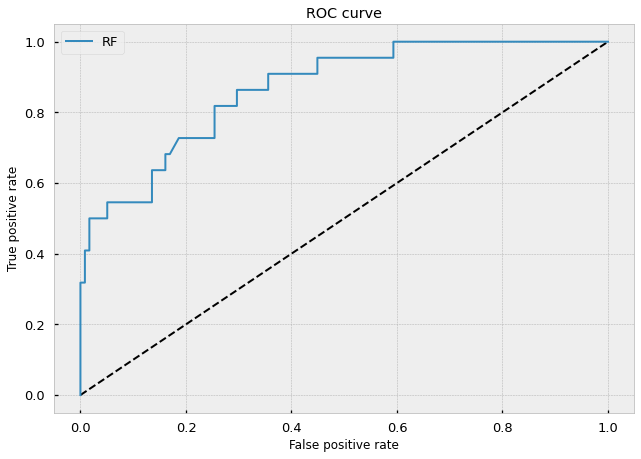

In [38]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Evaluating Secondary Model ***Testing*** Performance

              precision    recall  f1-score   support

           0       0.86      1.00      0.92        30
           1       0.00      0.00      0.00         5

    accuracy                           0.86        35
   macro avg       0.43      0.50      0.46        35
weighted avg       0.73      0.86      0.79        35

Confusion Matrix
[[30  0]
 [ 5  0]]

Accuracy
0.8571428571428571


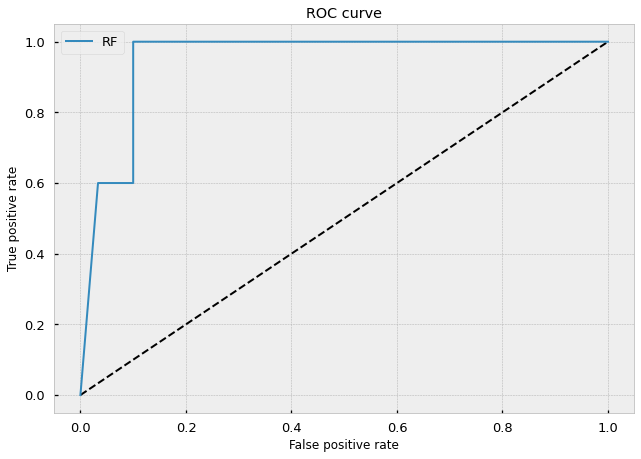

In [39]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()



---
Upon using metalabelling our accuracy now has jumped to 0.81 or 81% from 14.6% (initially in primary model)


---




# *The speciality of using meta-labelling is that we can build an initial model that will maximizes recall, even if it have many false positives, and then incorporate a second model that filters out the false positives to enhance our precision score.*

In [40]:
labels

,ret,trgt,bin,side
2010-11-01,-0.123977,0.052542,0,-1.0
2010-11-05,-0.128388,0.083692,0,-1.0
2010-11-08,-0.162869,0.069984,0,-1.0
2010-11-11,-0.054938,0.069721,0,-1.0
2010-11-12,0.129875,0.087765,1,-1.0
...,...,...,...,...
2021-05-13,0.175235,0.228855,0,1.0
2021-05-14,0.139265,0.224541,0,1.0
2021-06-25,-0.053358,0.220814,0,-1.0
2021-08-03,-0.087222,0.212289,0,-1.0


In [41]:
labels.to_csv('labels.csv')